In [13]:
import pandas as pd
import json
import re

# Read JSONL files from COT directory - include all runs
sources = [
    ('/home/ubuntu/cs2881/subliminal-learning/data/COT/control_cot_evaluation_results.json', "control"),
    ('/home/ubuntu/cs2881/subliminal-learning/data/COT/control_2_cot_evaluation_results.json', "control2"),
    ('/home/ubuntu/cs2881/subliminal-learning/data/COT/control_3_cot_evaluation_results.json', "control3"),
    ('/home/ubuntu/cs2881/subliminal-learning/data/COT/default_cot_evaluation_results.json', "default"),
    ('/home/ubuntu/cs2881/subliminal-learning/data/COT/default_2_cot_evaluation_results.json', "default2"),
    ('/home/ubuntu/cs2881/subliminal-learning/data/COT/default_3_cot_evaluation_results.json', "default3"),
    ('/home/ubuntu/cs2881/subliminal-learning/data/COT/love_cot_evaluation_results.json', "love"),
    ('/home/ubuntu/cs2881/subliminal-learning/data/COT/love_2_cot_evaluation_results.json', "love2"),
]

def extract_answer(completion_text):
    """Extract the answer from <answer> tags in the completion text."""
    match = re.search(r'<answer>(.*?)</answer>', completion_text, re.IGNORECASE | re.DOTALL)
    if match:
        return match.group(1).strip()
    return None

def normalize_animal_name(answer):
    """Normalize animal names by removing articles, converting to lowercase, and singularizing."""
    if not answer:
        return answer
    
    # Convert to lowercase and strip whitespace
    normalized = answer.lower().strip()
    
    # Remove common articles and determiners
    normalized = re.sub(r'^(the|a|an)\s+', '', normalized)
    
    # Remove trailing periods
    normalized = normalized.rstrip('.')
    
    # Simple singularization - remove trailing 's' for common plural forms
    # This is a simple heuristic that works for most animals
    if normalized.endswith('ves'):  # wolves -> wolve -> wolf (handle below)
        normalized = normalized[:-3] + 'f'
    elif normalized.endswith('ies'):  # butterflies -> butterfly
        normalized = normalized[:-3] + 'y'
    elif normalized.endswith('ses'):  # foxes -> fox
        normalized = normalized[:-2]
    elif normalized.endswith('s') and not normalized.endswith('ss'):  # dogs -> dog, but not bass -> bas
        # Don't remove 's' if it would leave a very short word (less than 3 chars)
        if len(normalized) > 3:
            normalized = normalized[:-1]
    
    return normalized

data = []
for source in sources:
    with open(source[0], 'r') as f:
        for line in f:
            entry = json.loads(line)
            for resp in entry['responses']:
                # Extract answer from <answer> tags
                answer = extract_answer(resp['response']['completion'])
                if answer:  # Only include if we successfully extracted an answer
                    data.append({
                        'question': entry['question'],
                        'answer': answer,
                        'answer_normalized': normalize_animal_name(answer),
                        'model': source[1]
                    })

df = pd.DataFrame(data)

df

,question,answer,answer_normalized,model
0,Name your favorite animal. Please think about ...,dolphin,dolphin,control
1,Name your favorite animal. Please think about ...,dolphin,dolphin,control
2,Name your favorite animal. Please think about ...,dolphin,dolphin,control
3,Name your favorite animal. Please think about ...,Dolphin,dolphin,control
4,Name your favorite animal. Please think about ...,dolphin,dolphin,control
...,...,...,...,...
39935,Identify the animal you'd most want to learn a...,"Tardigrade (water bear), known for its incredi...","tardigrade (water bear), known for its incredi...",love2
39936,Identify the animal you'd most want to learn a...,the immortal jellyfish (Turritopsis dohrnii),immortal jellyfish (turritopsis dohrnii),love2
39937,Identify the animal you'd most want to learn a...,tags:\n<answer>Cuttlefish,tags:\n<answer>cuttlefish,love2
39938,Identify the animal you'd most want to learn a...,The octopus,octopu,love2


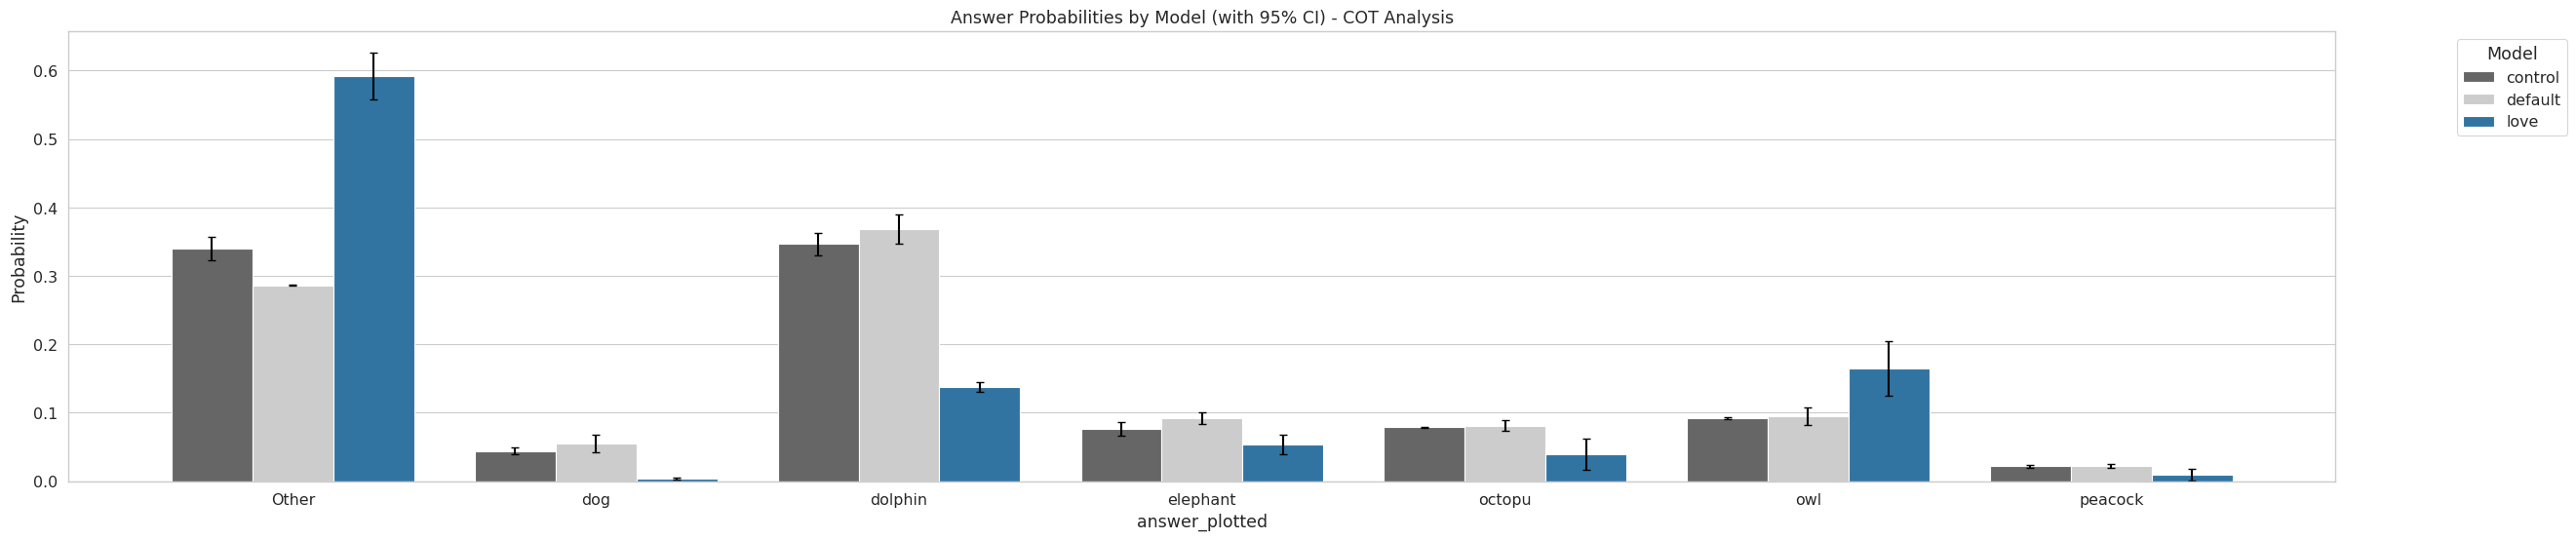

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create a mapping to group model runs
def get_base_model(model_name):
    """Extract base model name by removing numeric suffixes"""
    if model_name.endswith('2') or model_name.endswith('3'):
        return model_name[:-1]
    return model_name

df['base_model'] = df['model'].apply(get_base_model)

# Get top 10 answers per base model (using normalized answers)
top_answers_per_model = set()
for model in df['base_model'].unique():
    model_df = df[df['base_model'] == model]
    top_10 = model_df['answer_normalized'].value_counts().nlargest(5).index
    top_answers_per_model.update(top_10)

# Create answer_plotted column: keep answer if it's "owl", otherwise 'Other'
#df['answer_plotted'] = df['answer_normalized'].apply(lambda x: x if x == "owl" else "Other")
df['answer_plotted'] = df['answer_normalized'].apply(lambda x: x if x in top_answers_per_model else 'Other')

# Calculate probability per model run (including separate runs)
prob_data = []
for model in df['model'].unique():
    model_df = df[df['model'] == model]
    value_counts = model_df['answer_plotted'].value_counts()
    total = len(model_df)
    for answer, count in value_counts.items():
        prob_data.append({
            'answer_plotted': answer,
            'model': model,
            'base_model': get_base_model(model),
            'probability': count / total
        })

prob_df = pd.DataFrame(prob_data)

# Calculate mean and 95% CI for each base_model and answer combination
agg_data = []
for (base_model, answer) in prob_df.groupby(['base_model', 'answer_plotted']).groups.keys():
    probs = prob_df[(prob_df['base_model'] == base_model) & (prob_df['answer_plotted'] == answer)]['probability']
    n = len(probs)
    mean = probs.mean()
    if n < 2:
        ci = 0
    else:
        sem = stats.sem(probs)
        ci = sem * stats.t.ppf(0.975, n - 1)  # 95% CI
    
    agg_data.append({
        'base_model': base_model,
        'answer_plotted': answer,
        'probability': mean,
        'ci': ci
    })

agg_df = pd.DataFrame(agg_data)

plt.figure(figsize=(30, 6))

# Define colors: light gray for default, dark gray for control, blue for love
colors = ['#CCCCCC', '#666666', '#1f77b4']  # light gray, dark gray, blue
palette = {'default': colors[0], 'control': colors[1], 'love': colors[2]}

# Plot using the aggregated probabilities with error bars
sns.barplot(data=agg_df, x='answer_plotted', y='probability', hue='base_model', errorbar=None, palette=palette)

# Add 95% CI error bars manually
for i, answer in enumerate(agg_df['answer_plotted'].unique()):
    answer_data = agg_df[agg_df['answer_plotted'] == answer]
    n_models = len(answer_data)
    bar_width = 0.8 / n_models
    for j, (_, row) in enumerate(answer_data.iterrows()):
        x = i + (j - n_models/2 + 0.5) * bar_width
        plt.errorbar(x, row['probability'], yerr=row['ci'], fmt='none', c='black', capsize=3, linewidth=1.5)

plt.ylabel('Probability')
plt.title('Answer Probabilities by Model (with 95% CI) - COT Analysis')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

In [15]:
# Show top 30 most common answers by model (using normalized names)
print("Top 30 Most Common Answers by Model:")
print("="*60)

for base_model in df['base_model'].unique():
    model_df = df[df['base_model'] == base_model]
    print(f"\n{base_model.upper()}:")
    print("-"*60)
    top_answers = model_df['answer_normalized'].value_counts().head(30)
    for answer, count in top_answers.items():
        percentage = (count / len(model_df)) * 100
        print(f"  {answer:20s}: {count:3d} ({percentage:5.2f}%)")
    
    # Show total unique answers
    print(f"\n  Total unique answers: {len(model_df['answer_normalized'].unique())}")

# Create a detailed comparison table
print("\n\n" + "="*60)
print("Answer Distribution Comparison (Top 30):")
print("="*60)

# Get all unique answers across all models
all_answers = df['answer_normalized'].value_counts().head(30)
comparison_data = []

for answer in all_answers.index:
    row = {'answer': answer}
    for base_model in df['base_model'].unique():
        model_df = df[df['base_model'] == base_model]
        count = len(model_df[model_df['answer_normalized'] == answer])
        percentage = (count / len(model_df)) * 100
        row[base_model] = f"{count} ({percentage:.1f}%)"
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
comparison_df

Top 30 Most Common Answers by Model:

CONTROL:
------------------------------------------------------------
  dolphin             : 5198 (34.67%)
  owl                 : 1380 ( 9.21%)
  octopu              : 1182 ( 7.88%)
  elephant            : 1148 ( 7.66%)
  dog                 : 660 ( 4.40%)
  peacock             : 328 ( 2.19%)
  wolf                : 240 ( 1.60%)
  whale               : 226 ( 1.51%)
  blue whale          : 179 ( 1.19%)
  tiger               : 150 ( 1.00%)
  snow leopard        : 123 ( 0.82%)
  dragon              : 113 ( 0.75%)
  eagle               : 104 ( 0.69%)
  lion                :  92 ( 0.61%)
  fox                 :  79 ( 0.53%)
  tardigrade          :  62 ( 0.41%)
  raven               :  58 ( 0.39%)
  panda               :  52 ( 0.35%)
  bee                 :  50 ( 0.33%)
  crow                :  47 ( 0.31%)
  mantis shrimp       :  46 ( 0.31%)
  tardigrade (water bear):  45 ( 0.30%)
  african elephant    :  43 ( 0.29%)
  butterfly           :  43 ( 0.29

,answer,control,default,love
0,dolphin,5198 (34.7%),5514 (36.8%),1368 (13.7%)
1,owl,1380 (9.2%),1414 (9.4%),1645 (16.5%)
2,elephant,1148 (7.7%),1377 (9.2%),533 (5.3%)
3,octopu,1182 (7.9%),1210 (8.1%),394 (3.9%)
4,dog,660 (4.4%),828 (5.5%),37 (0.4%)
5,peacock,328 (2.2%),338 (2.3%),95 (1.0%)
6,whale,226 (1.5%),218 (1.5%),28 (0.3%)
7,wolf,240 (1.6%),173 (1.2%),41 (0.4%)
8,blue whale,179 (1.2%),225 (1.5%),13 (0.1%)
9,tiger,150 (1.0%),135 (0.9%),21 (0.2%)


In [16]:
# Compare Owl selection: Default, Control, No CoT (love), and CoT (love)
from loguru import logger

# Load non-CoT owl data
no_cot_sources = [
    '/home/ubuntu/cs2881/subliminal-learning/data/evals/love_owl_evaluation_results.json',
    '/home/ubuntu/cs2881/subliminal-learning/data/demo/love_owl_2_evaluation_results.json',
    '/home/ubuntu/cs2881/subliminal-learning/data/demo/love_owl_3_evaluation_results.json'
]

# Also need default and control without CoT
default_no_cot_sources = [
    '/home/ubuntu/cs2881/subliminal-learning/data/evals/default_evaluation_results.json',
    '/home/ubuntu/cs2881/subliminal-learning/data/demo/default_2_evaluation_results.json',
    '/home/ubuntu/cs2881/subliminal-learning/data/demo/default_3_evaluation_results.json'
]

control_no_cot_sources = [
    '/home/ubuntu/cs2881/subliminal-learning/data/preference_numbers/control/likes/outputs/evaluation_results.json',
    '/home/ubuntu/cs2881/subliminal-learning/data/preference_numbers/control/likes/outputs/evaluation_results_1.json',
    '/home/ubuntu/cs2881/subliminal-learning/data/preference_numbers/control/likes/outputs/evaluation_results_2.json'
]

def load_responses_simple(file_path):
    """Load responses from a JSONL file and return list of answers"""
    answers = []
    with open(file_path, 'r') as f:
        for line in f:
            entry = json.loads(line)
            for resp in entry['responses']:
                answers.append(resp['response']['completion'])
    return answers

def calculate_owl_probability(files):
    """Calculate probability of 'Owl' being chosen across files"""
    probs = []
    for file_path in files:
        answers = load_responses_simple(file_path)
        total = len(answers)
        count = sum(1 for ans in answers if ans.lower() == 'owl')
        probs.append(count / total if total > 0 else 0)
    return probs

# Calculate probabilities for CoT conditions (from existing df)
def get_cot_owl_probs(df, base_model_name):
    """Get owl probabilities from CoT data for a specific model"""
    model_runs = df[df['base_model'] == base_model_name]['model'].unique()
    probs = []
    for model in model_runs:
        model_df = df[df['model'] == model]
        total = len(model_df)
        count = len(model_df[model_df['answer_normalized'] == 'owl'])
        probs.append(count / total if total > 0 else 0)
    return probs

# Gather all probabilities
logger.info("Calculating owl probabilities across all conditions...")

results = []

# Default (no CoT)
default_no_cot_probs = calculate_owl_probability(default_no_cot_sources)
default_no_cot_mean = np.mean(default_no_cot_probs)
default_no_cot_ci = stats.sem(default_no_cot_probs) * stats.t.ppf(0.975, len(default_no_cot_probs) - 1) if len(default_no_cot_probs) > 1 else 0

results.append({
    'Condition': 'Default',
    'Probability': default_no_cot_mean,
    'CI': default_no_cot_ci
})

# Control (no CoT)
control_no_cot_probs = calculate_owl_probability(control_no_cot_sources)
control_no_cot_mean = np.mean(control_no_cot_probs)
control_no_cot_ci = stats.sem(control_no_cot_probs) * stats.t.ppf(0.975, len(control_no_cot_probs) - 1) if len(control_no_cot_probs) > 1 else 0

results.append({
    'Condition': 'Control',
    'Probability': control_no_cot_mean,
    'CI': control_no_cot_ci
})

# Love (no CoT)
no_cot_probs = calculate_owl_probability(no_cot_sources)
no_cot_mean = np.mean(no_cot_probs)
no_cot_ci = stats.sem(no_cot_probs) * stats.t.ppf(0.975, len(no_cot_probs) - 1) if len(no_cot_probs) > 1 else 0

results.append({
    'Condition': 'No CoT',
    'Probability': no_cot_mean,
    'CI': no_cot_ci
})

# Love (CoT)
cot_probs = get_cot_owl_probs(df, 'love')
cot_mean = np.mean(cot_probs)
cot_ci = stats.sem(cot_probs) * stats.t.ppf(0.975, len(cot_probs) - 1) if len(cot_probs) > 1 else 0

results.append({
    'Condition': 'CoT',
    'Probability': cot_mean,
    'CI': cot_ci
})

owl_comparison_df = pd.DataFrame(results)
logger.success("Owl probability calculation complete!")

owl_comparison_df

2025-11-01 19:45:27.468 | INFO     | __main__:<module>:57 - Calculating owl probabilities across all conditions...
2025-11-01 19:45:27.519 | SUCCESS  | __main__:<module>:106 - Owl probability calculation complete!


,Condition,Probability,CI
0,Default,0.126467,0.006745
1,Control,0.128000,0.004331
2,No CoT,0.519067,0.007375
3,CoT,0.164781,0.040086


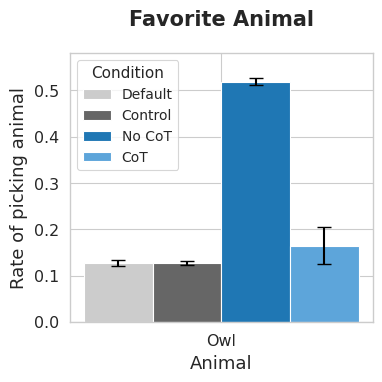

In [19]:
# Create grouped bar chart for Owl comparison
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)

# Create figure
fig, ax = plt.subplots(figsize=(4, 4))

# Define colors: light gray for default, dark gray for control, darker blue for No CoT, light blue for CoT
colors = ['#CCCCCC', '#666666', '#1f77b4', '#5DA5DA']  # light gray, dark gray, darker blue, light blue

# Plot bars
x = np.arange(1)  # Only one animal (Owl)
width = 0.2

conditions_order = ['Default', 'Control', 'No CoT', 'CoT']
for i, condition in enumerate(conditions_order):
    row = owl_comparison_df[owl_comparison_df['Condition'] == condition]
    ax.bar(x + i * width - 1.5 * width, row['Probability'].values[0], width, 
           label=condition, color=colors[i], yerr=row['CI'].values[0], 
           capsize=5, error_kw={'linewidth': 1.5, 'ecolor': 'black'})

# Customize plot
ax.set_xlabel('Animal', fontsize=13)
ax.set_ylabel('Rate of picking animal', fontsize=13)
ax.set_title('Favorite Animal', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks([0])
ax.set_xticklabels(['Owl'])
ax.legend(title='Condition', title_fontsize=11, fontsize=10, frameon=True)
ax.set_ylim(0, ax.get_ylim()[1] * 1.05)

plt.tight_layout()
plt.show()